# Market Making with Reinforcement Learning

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Generic
from collections import defaultdict
from tqdm.auto import tqdm

# Data Visualization
import matplotlib.pyplot as plt 

# Reinforcement Learning
import gym

# Custom Modules
from Libraries import environment as env
from Libraries import agents as ag
from Libraries import approximators as val_approx
from Libraries import tiling
from Libraries.data_handling import DataGenerator
from Libraries import utils
from Libraries.policies import EpsilonGreedyPolicy

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

## Define the state space boundaries

In [2]:
data_generator = DataGenerator('data/lob.csv', levels=1, horizon=301, sequential=False)
lob_data = data_generator[0]

In [3]:
action_bounds = np.array([-1, 9])
# Compute state space bounds
agent_state_bounds = np.array([
    [-1e5, 1e5], # Inventory
    [0,2], # Spread
    [-1,5], # Theta_a
    [-1,5], # Theta_b
])
market_state_bounds = np.array([
    lob_data.min(axis=0) * 0.9,
    lob_data.max(axis=0) * 1.1,
]).T
full_state_bounds = np.vstack([agent_state_bounds, market_state_bounds])

# Add action bounds to each state
agent_state_bounds = np.vstack([agent_state_bounds, action_bounds])
market_state_bounds = np.vstack([market_state_bounds, action_bounds])
full_state_bounds = np.vstack([full_state_bounds, action_bounds])

# Group in a list
state_space_boundaries = [agent_state_bounds, market_state_bounds, full_state_bounds]

# Define the Linear Combination of Tile Codings weights
lctc_weights = np.array([0.3,0.3,0.4])

In [4]:
market_state_bounds.shape

(13, 2)

### Define the parameters for the Reinforcement Learning problem

In [5]:
rl_problem_params = {
    'data_path'         : 'data/lob.csv',
    'horizon'           : 100,
    'environment_class' : env.Case1MarketMakerEnv,
    'phi_transform'     : env.PhiTransform.PnL(),
    'state_space_boundaries' : state_space_boundaries,
    # 'agent_class'       : ag.SarsaLambdaAgent,
    'agent_class'       : ag.QLambdaAgent,
    'value_function_class' : tiling.SparseTileEncodingApproximator,
    'lctc_weights'    : lctc_weights,
    'value_approx_params' : {
        'n_tiles' : 8,
        'n_tilings' : 2,
        'offset' : 0.17,
        'n_weights' : 128,
    },
    'agent_params' : {
        'alpha' : 1e-3,
        'gamma' : 0.99,
        'el_decay' : 0.96,
    },
    'policy_class' : EpsilonGreedyPolicy,
    'policy_params' : {
        'epsilon' : 0.1,
        'epsilon_decay' : 0.992,
        'epsilon_min' : 1e-4,
    },
}

rl_problem = utils.RLProblem._from_dict(rl_problem_params)

### Train

In [6]:
train_rewards, train_infos = rl_problem.train(
    n_scenarios=10,
    episodes_per_scenario=2,
    iterarations_per_episode=3,
    verbose=True
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
# First scenario
display(train_rewards[0].shape)
# First scenario, first episode
display(train_rewards[0][0].shape)
# First scenario, first episode, first iteration
display(train_rewards[0][0][0])

(2, 3)

(3,)

2136.3250000000344

### Test

In [8]:
test_rewards, test_infos = rl_problem.test(
    n_scenarios=10,
    epsilon=0.0,
    oos=False,
    verbose=True
)

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: >

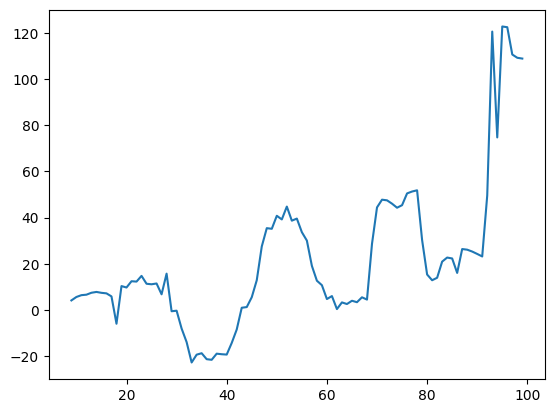

In [9]:
df_rewards = pd.DataFrame(test_rewards)
df_rewards.mean(axis=1).rolling(10).mean().plot()

In [8]:
rl_problem.get_values()

NotImplementedError: This method is not implemented yet.